In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-06 21:34:24.070255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-30(ii) dataset

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/2.4GHz/Device-30(iii)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[-0.015625 +0.j         0.0234375+0.0078125j  0.0078125+0.j        ...
  0.       +0.0234375j  0.03125  +0.0078125j  0.015625 +0.0078125j]
2048
86010
(2048, 86010)
[0.02965036 0.02421156 0.01498892 ... 0.01784609 0.01751189 0.02130463]
0
(10000, 2048)
(10000,)
[-0.0234375+0.0234375j  0.       -0.0390625j  0.0234375+0.015625j  ...
  0.015625 +0.0234375j  0.0078125+0.015625j   0.0234375+0.0078125j]
2048
78192
(2048, 78192)
[0.02501178 0.02254374 0.02445342 ... 0.01480449 0.01424241 0.0179573 ]
1
(20000, 2048)
(20000,)
[0.015625 +0.j        0.0078125+0.0078125j 0.0078125+0.j        ...
 0.0234375+0.015625j  0.0078125+0.0234375j 0.0078125-0.0234375j]
2048
77681
(2048, 77681)
[0.03295958 0.02481395 0.01668315 ... 0.01402689 0.01567082 0.02230988]
2
(30000, 2048)
(30000,)
[ 0.       +0.015625j   0.       +0.j        -0.015625 +0.015625j  ...
  0.0078125+0.015625j   0.046875 +0.0078125j -0.0078125+0.j       ]
2048
97136
(2048, 97136)
[0.0352106  0.02555366 0.0206623  ... 0.01964847 0.02377083

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-30(iii) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-04-06 21:49:43.606145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 10.0356 - accuracy: 0.1282
test loss, test acc: [10.035614967346191, 0.1282375007867813]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 1 1 ... 3 3 3]
4
[[   1 5136 2567    7 2247    6    7   29]
 [   0 1963 6929    1   46    5   14 1042]
 [   0 8526   12   10 1419    3   26    4]
 [   3 8764   18   26 1134    4   32   19]
 [   0 1719   11   17 8234    5   10    4]
 [   0 4645    9  255 5040    5   29   17]
 [   6  119    6   59 9781    6   11   12]
 [   0   91    0 9775   99    0   28    7]]
              precision    recall  f1-score   support

           0       0.10      0.00      0.00     10000
           1       0.06      0.20      0.10     10000
           2       0.00      0.00      0.00     10000
           3       0.00      0.00      0.00     10000
           4       0.29      0.82      0.43     10000
           5       0.15      0.00      0.00     10000
           6       0.07      0.00      0.00     10000
           7       0.01      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.09      0.13  

Test Accuracy:0.1282375


Text(0.5, 1.0, 'Accuracy:0.128')

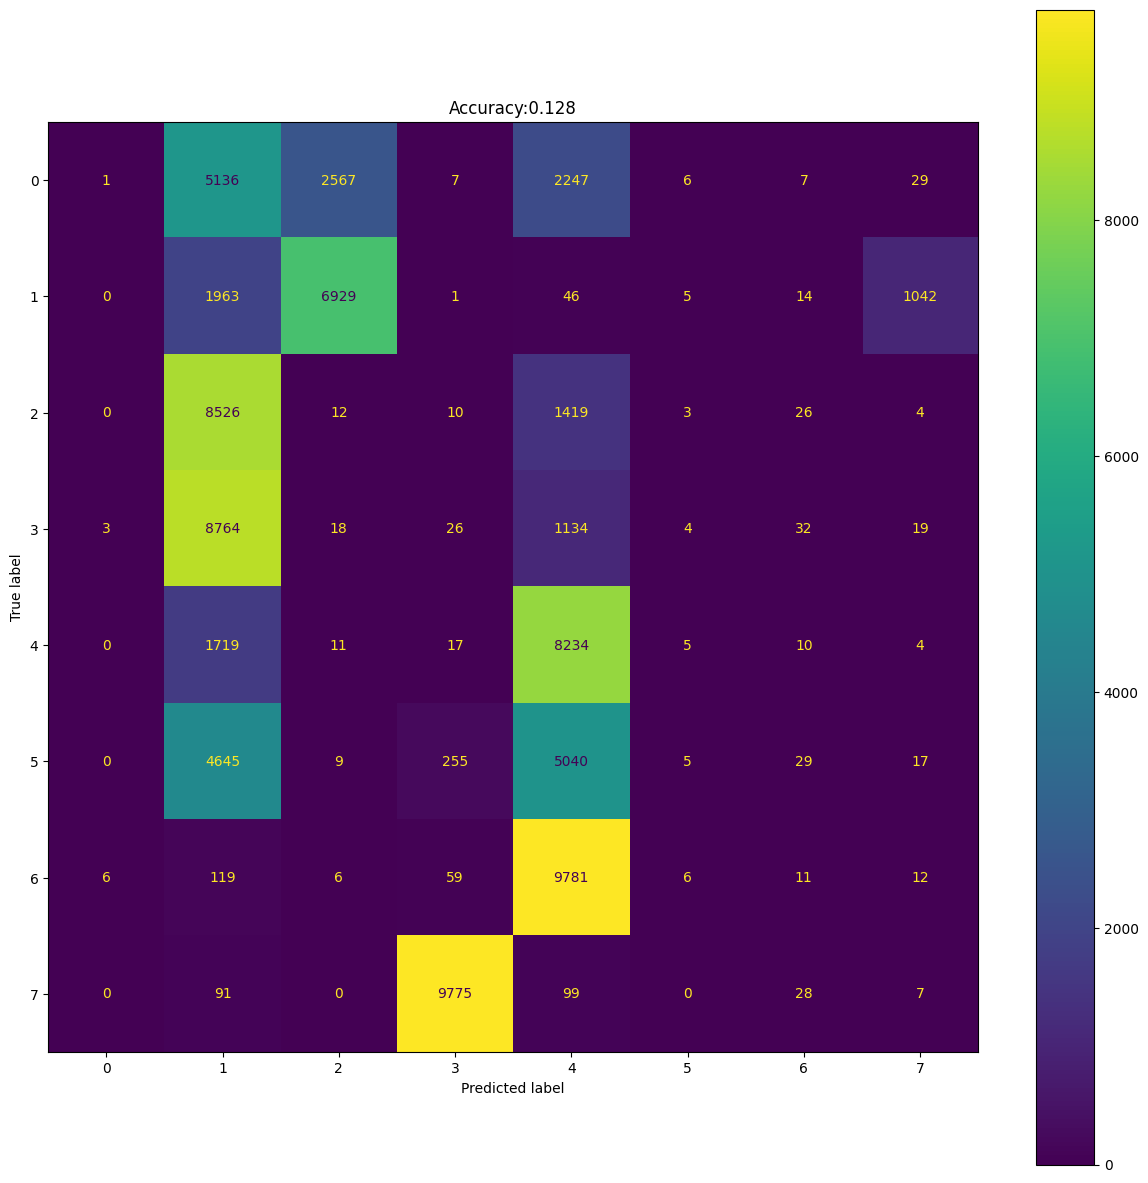

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

Nordic Device-25(i) model to Nordic Device-30(iii) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.6156 - accuracy: 0.2626
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1838 - accuracy: 0.5998
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0158 - accuracy: 0.6615
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.9330 - accuracy: 0.7173
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8827 - accuracy: 0.7531
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.8481 - accuracy: 0.7724
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8227 - accuracy: 0.7853
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.8028 - accuracy: 0.7948
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.7869 - accuracy: 0.7995
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss:

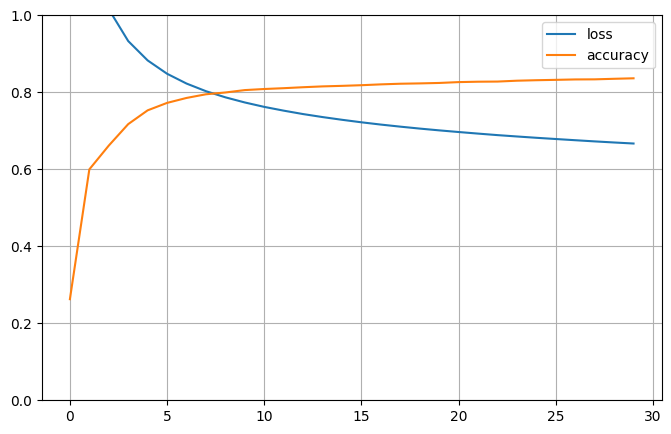

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.6656 - accuracy: 0.8351
test loss, test acc: [0.6655526757240295, 0.8350625038146973]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[5 0 0 ... 7 7 7]
5
[[8565  777  585   27   26    9    4    7]
 [ 640 9317   14   15    8    3    1    2]
 [ 627   32 6110 2662  525   27    3   14]
 [  83   70 1738 6967  955  149    6   32]
 [  57   18   43  353 8838  610   63   18]
 [  27   48   15   77  163 8583 1021   66]
 [  27   45    4   12  100 1075 8729    8]
 [   6   18    1   45   14  161   59 9696]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     10000
           1       0.90      0.93      0.92     10000
           2       0.72      0.61      0.66     10000
           3       0.69      0.70      0.69     10000
           4       0.83      0.88      0.86     10000
           5       0.81      0.86      0.83     10000
           6       0.88      0.87      0.88     10000
           7       0.99      0.97      0.98     10000

    accuracy                           0.84     80000
   macro avg       0.83      0.84   

Test Accuracy:0.8350625


Text(0.5, 1.0, 'Accuracy:0.835')

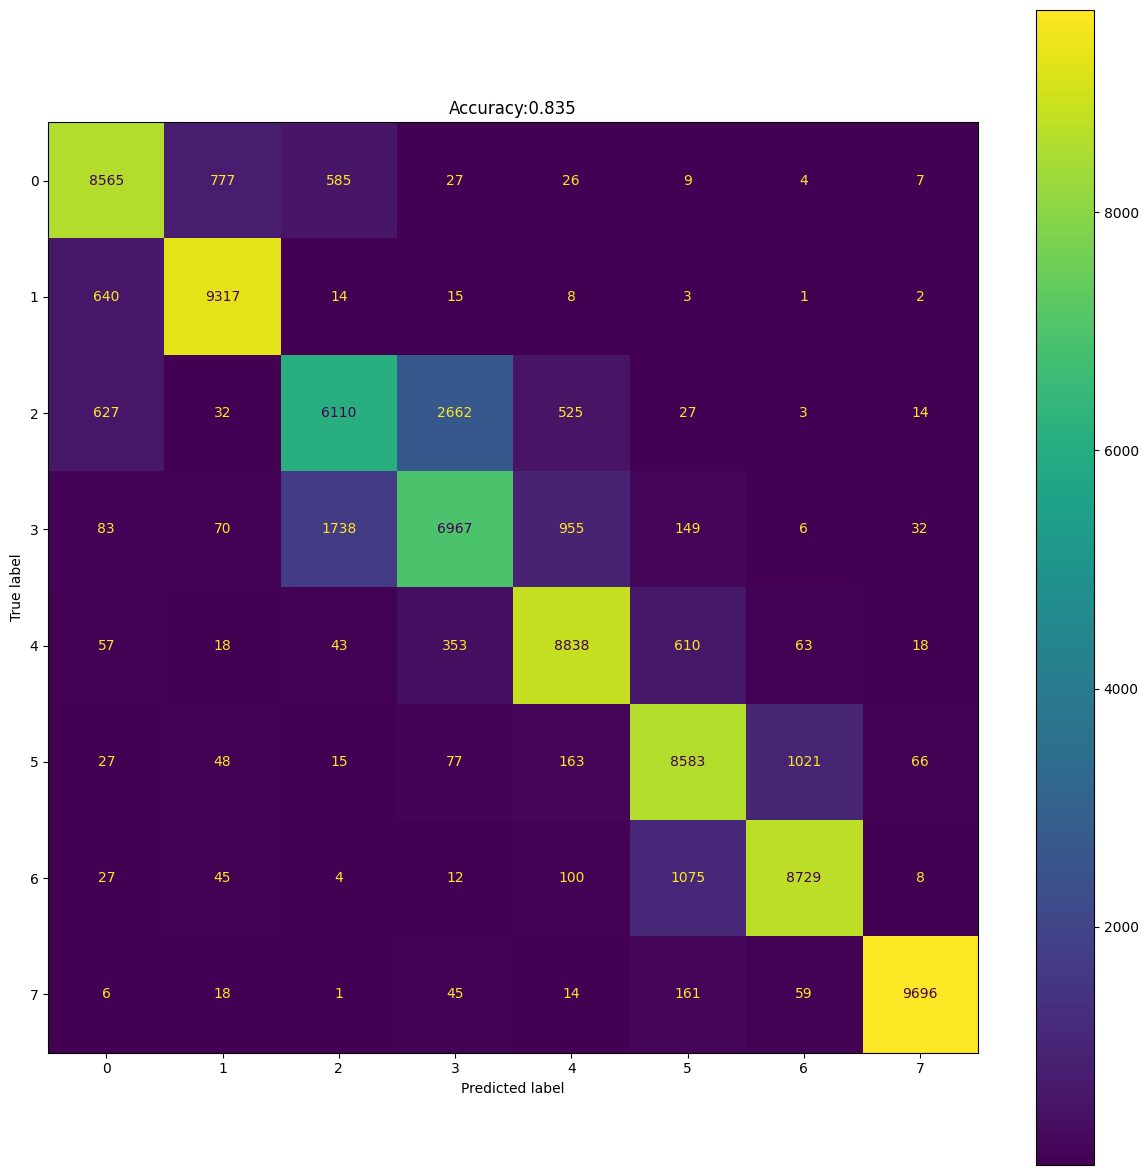

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-25(ii) model to Nordic Device-30(iii) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 7.5437 - accuracy: 0.0679
test loss, test acc: [7.543678283691406, 0.06786250323057175]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[6 6 6 ... 3 3 3]
6
[[   0 3252    0   56    0 2838 3852    2]
 [   1  129    2    3    0 9843   21    1]
 [   1   38    0   11    0  307 9641    2]
 [   2   40    1 1759    0   35 8156    7]
 [   0  381    2 6420    2   22 3171    2]
 [   0   39    0   84    0   55 9818    4]
 [   6   35    0 6467    5   12 3475    0]
 [   1   13    0 9655    3    5  314    9]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.03      0.01      0.02     10000
           2       0.00      0.00      0.00     10000
           3       0.07      0.18      0.10     10000
           4       0.20      0.00      0.00     10000
           5       0.00      0.01      0.00     10000
           6       0.09      0.35      0.14     10000
           7       0.33      0.00      0.00     10000

    accuracy                           0.07     80000
   macro avg       0.09      0.07   

Test Accuracy:0.0678625


Text(0.5, 1.0, 'Accuracy:0.068')

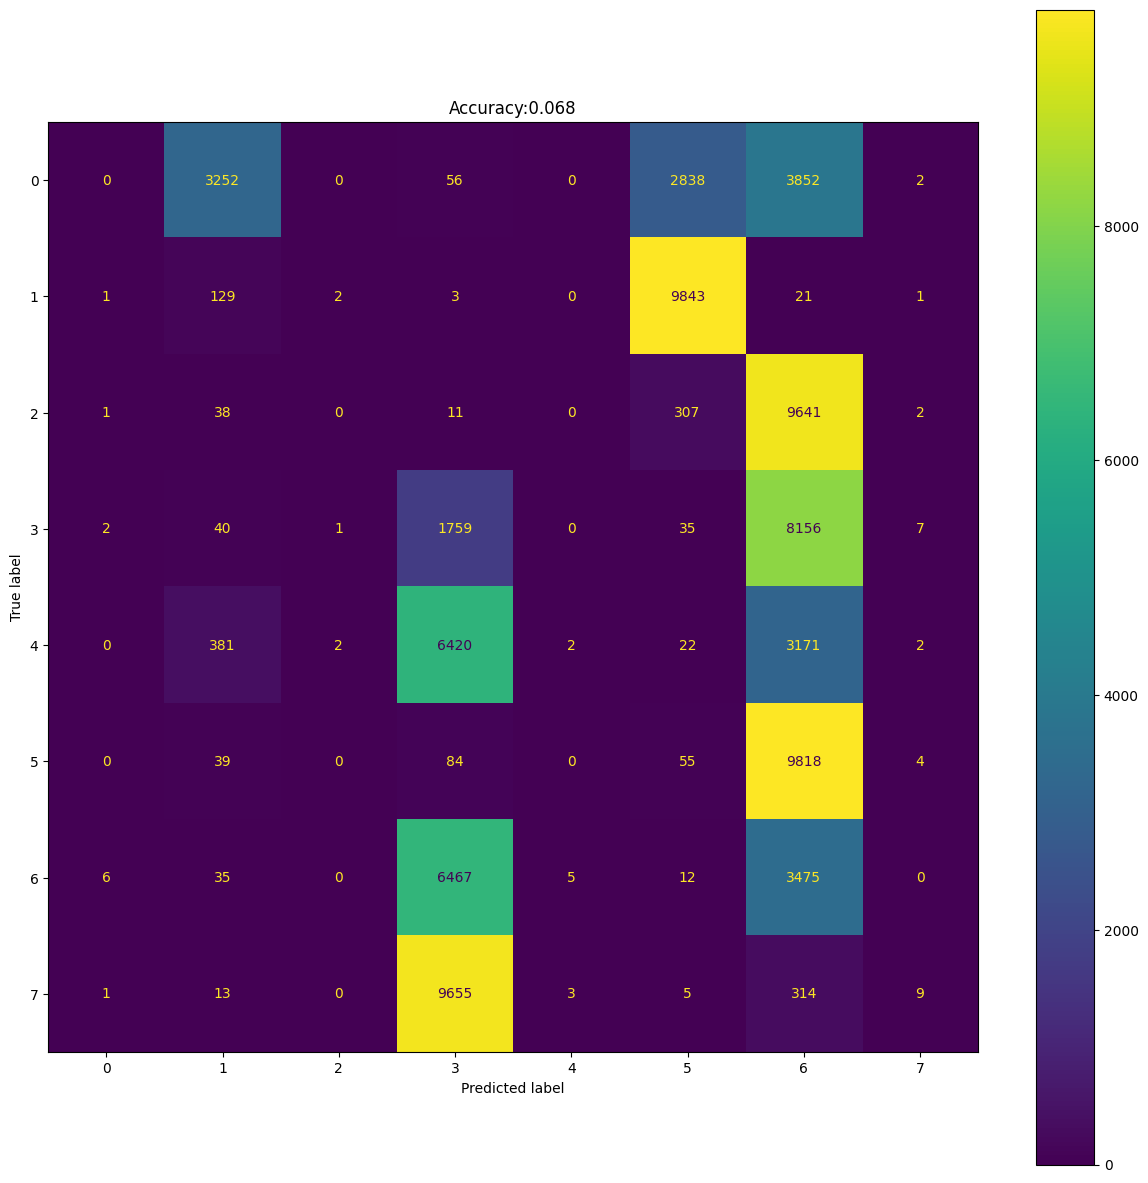

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [23]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [24]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [25]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 4ms/step - loss: 1.7241 - accuracy: 0.3722
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.9263 - accuracy: 0.7332
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.8301 - accuracy: 0.8046
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7772 - accuracy: 0.8296
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7395 - accuracy: 0.8441
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7100 - accuracy: 0.8535
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6863 - accuracy: 0.8602
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6663 - accuracy: 0.8656
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6492 - accuracy: 0.8700
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

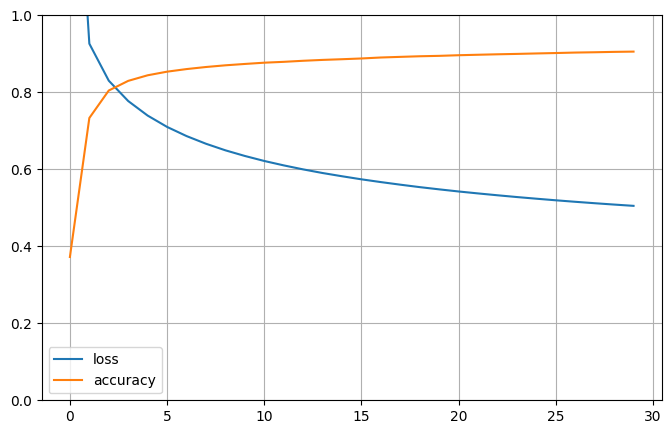

In [26]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.5030 - accuracy: 0.9056
test loss, test acc: [0.5030484795570374, 0.9055749773979187]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 0 2 ... 7 7 7]
5
[[8692  415  508   41  337    1    5    1]
 [ 352 9585   53    3    7    0    0    0]
 [ 511   62 9142  195   50   40    0    0]
 [  58   17  274 7678  545  844  561   23]
 [ 220   13   70  291 9366    5   32    3]
 [  36   24  159  158   59 9230  316   18]
 [  29   17   15   35   64  555 9246   39]
 [   8    4   29   83   26  119  224 9507]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     10000
           1       0.95      0.96      0.95     10000
           2       0.89      0.91      0.90     10000
           3       0.90      0.77      0.83     10000
           4       0.90      0.94      0.92     10000
           5       0.86      0.92      0.89     10000
           6       0.89      0.92      0.91     10000
           7       0.99      0.95      0.97     10000

    accuracy                           0.91     80000
   macro avg       0.91      0.91  

Test Accuracy:0.905575


Text(0.5, 1.0, 'Accuracy:0.906')

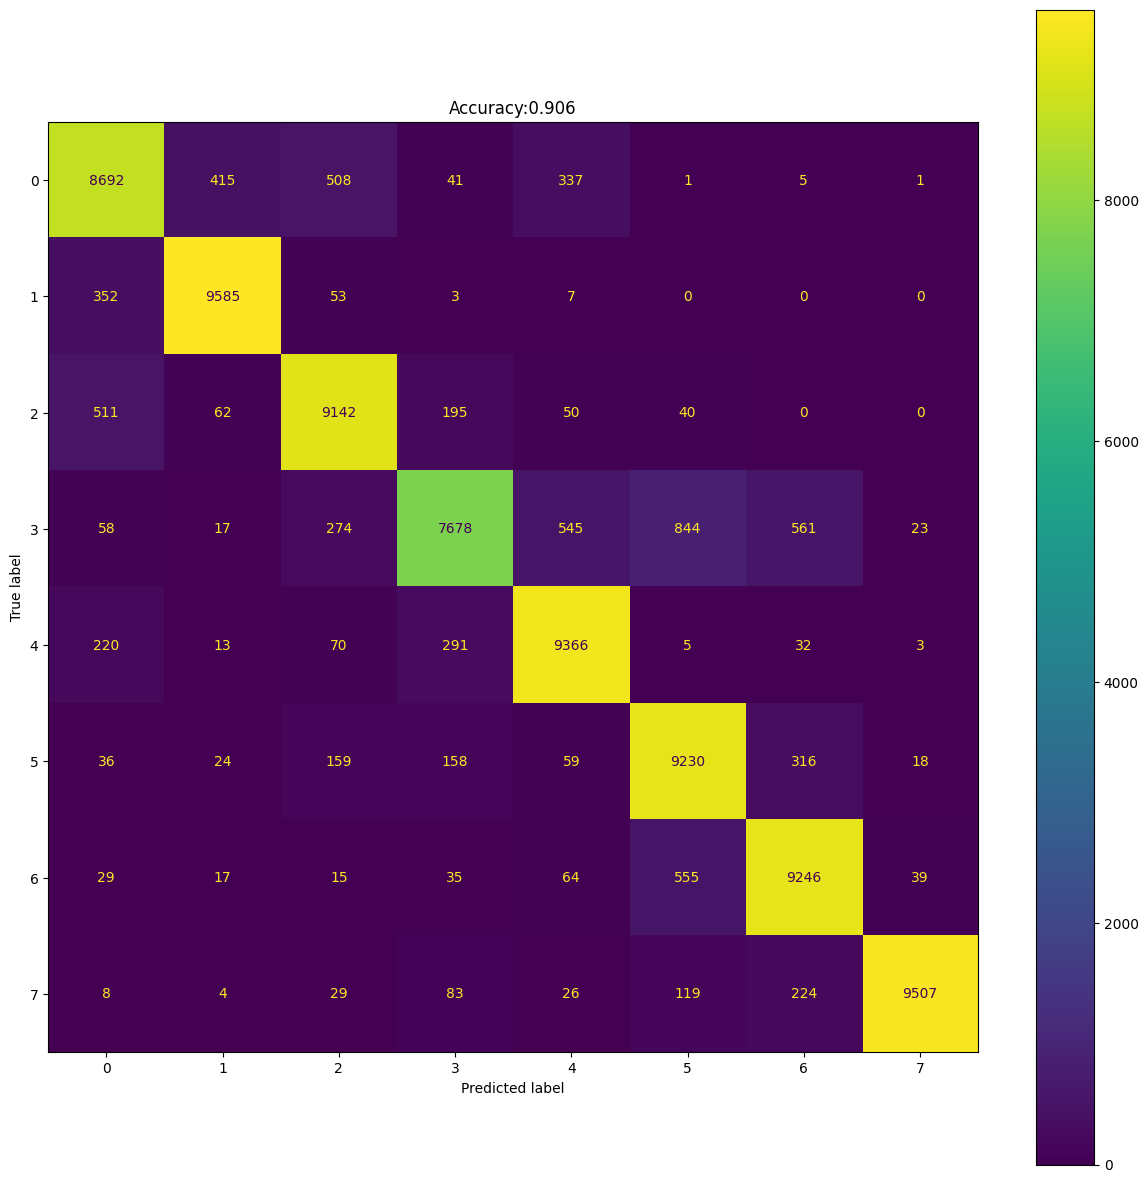

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-30(iii) dataset 

In [30]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

In [34]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 9.9928 - accuracy: 0.1118
test loss, test acc: [9.992802619934082, 0.11183749884366989]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 1 1 ... 3 3 3]
3
[[   0 9825    3    6   69   38   53    6]
 [   2 8889    1    1   33  337   40  697]
 [   1 6882    6    8   14    2 3086    1]
 [   0  401   14   13  150    2 9420    0]
 [   0 9892    1   37    4    3   61    2]
 [   0 1291    4 8440   31    0  226    8]
 [   4   65    0 9857   20   18   35    1]
 [   0   47    0 9814   17    1  121    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.24      0.89      0.38     10000
           2       0.21      0.00      0.00     10000
           3       0.00      0.00      0.00     10000
           4       0.01      0.00      0.00     10000
           5       0.00      0.00      0.00     10000
           6       0.00      0.00      0.00     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.11     80000
   macro avg       0.06      0.11  

Test Accuracy:0.1118375


Text(0.5, 1.0, 'Accuracy:0.112')

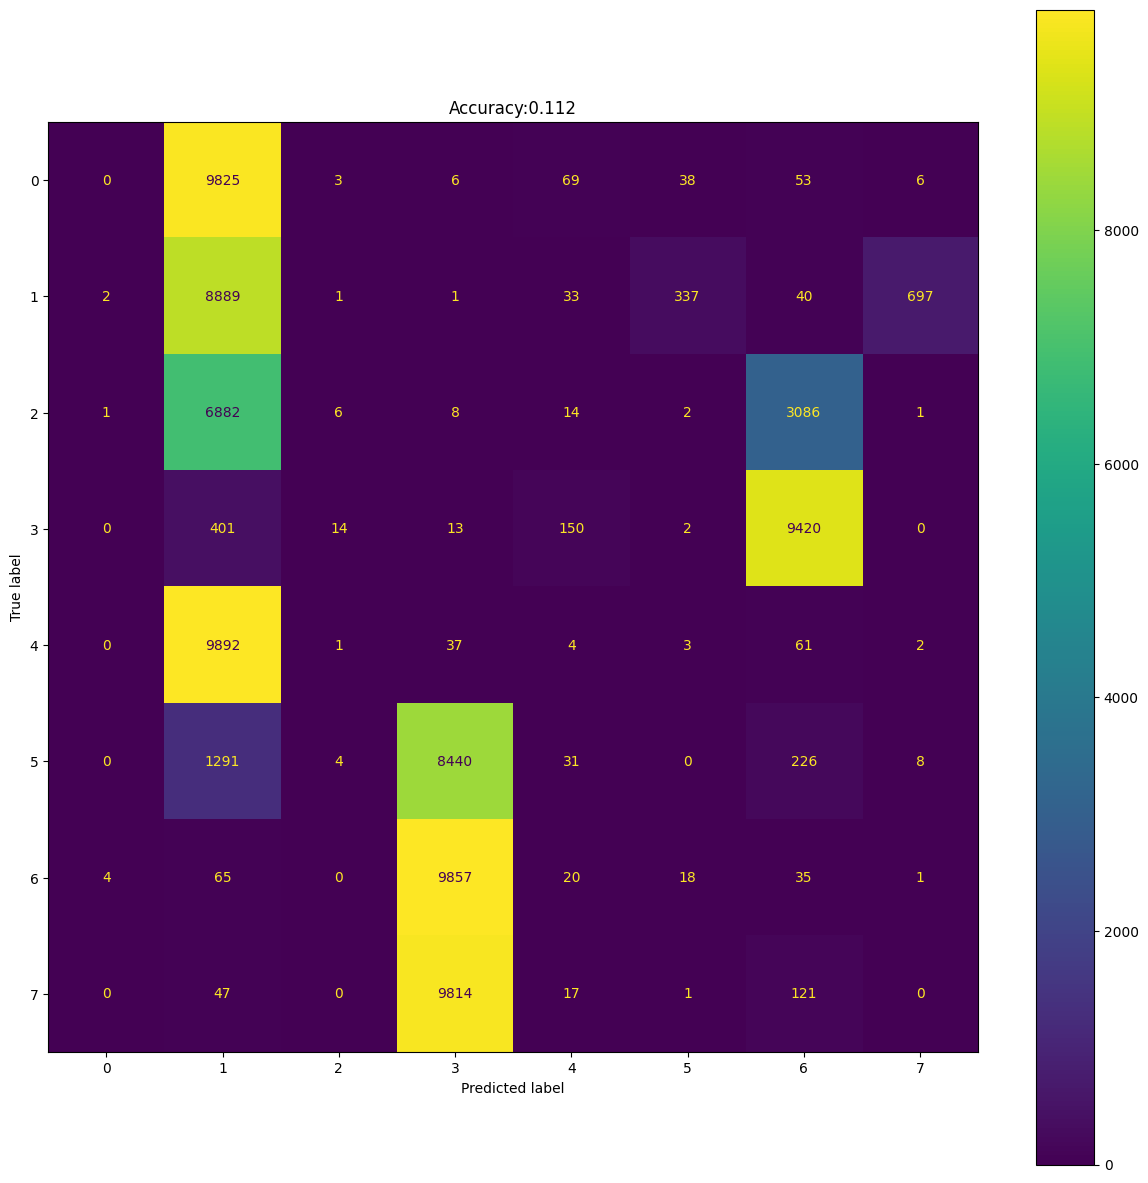

In [36]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning @2.4GHz

Nordic Device-25(iii) model to Nordic Device-30(iii) dataset 

In [40]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [41]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [42]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.4045 - accuracy: 0.2717
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0012 - accuracy: 0.6580
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.8418 - accuracy: 0.7608
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7502 - accuracy: 0.8393
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.6899 - accuracy: 0.8783
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6481 - accuracy: 0.8891
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6173 - accuracy: 0.8933
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5938 - accuracy: 0.8960
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5750 - accuracy: 0.8979
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss:

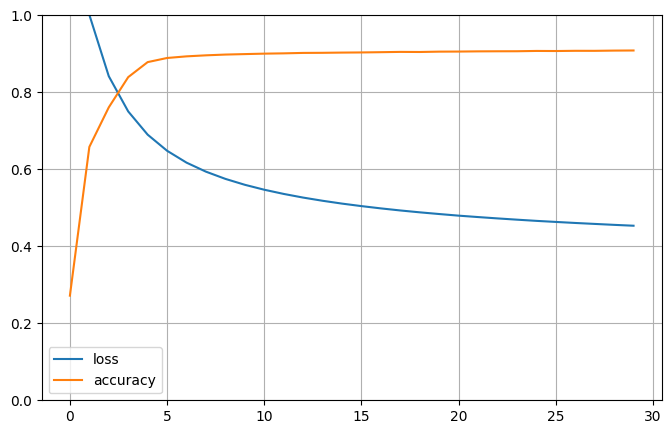

In [43]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [44]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.4528 - accuracy: 0.9079
test loss, test acc: [0.45281273126602173, 0.9078500270843506]


In [45]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[5 0 0 ... 7 7 7]
5
[[8628 1085  153   61   52    3   16    2]
 [1215 8737    9   12   17    2    8    0]
 [ 289    6 8246 1257  146   34   12   10]
 [  54    3  726 9108   49   37   12   11]
 [  31   12   91   18 9567  235   41    5]
 [   9    9   37  143  247 9222  292   41]
 [  16   14   12   18   47  163 9669   61]
 [   3    1   12   63   31  111  328 9451]]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     10000
           1       0.89      0.87      0.88     10000
           2       0.89      0.82      0.86     10000
           3       0.85      0.91      0.88     10000
           4       0.94      0.96      0.95     10000
           5       0.94      0.92      0.93     10000
           6       0.93      0.97      0.95     10000
           7       0.99      0.95      0.97     10000

    accuracy                           0.91     80000
   macro avg       0.91      0.91   

Test Accuracy:0.90785


Text(0.5, 1.0, 'Accuracy:0.908')

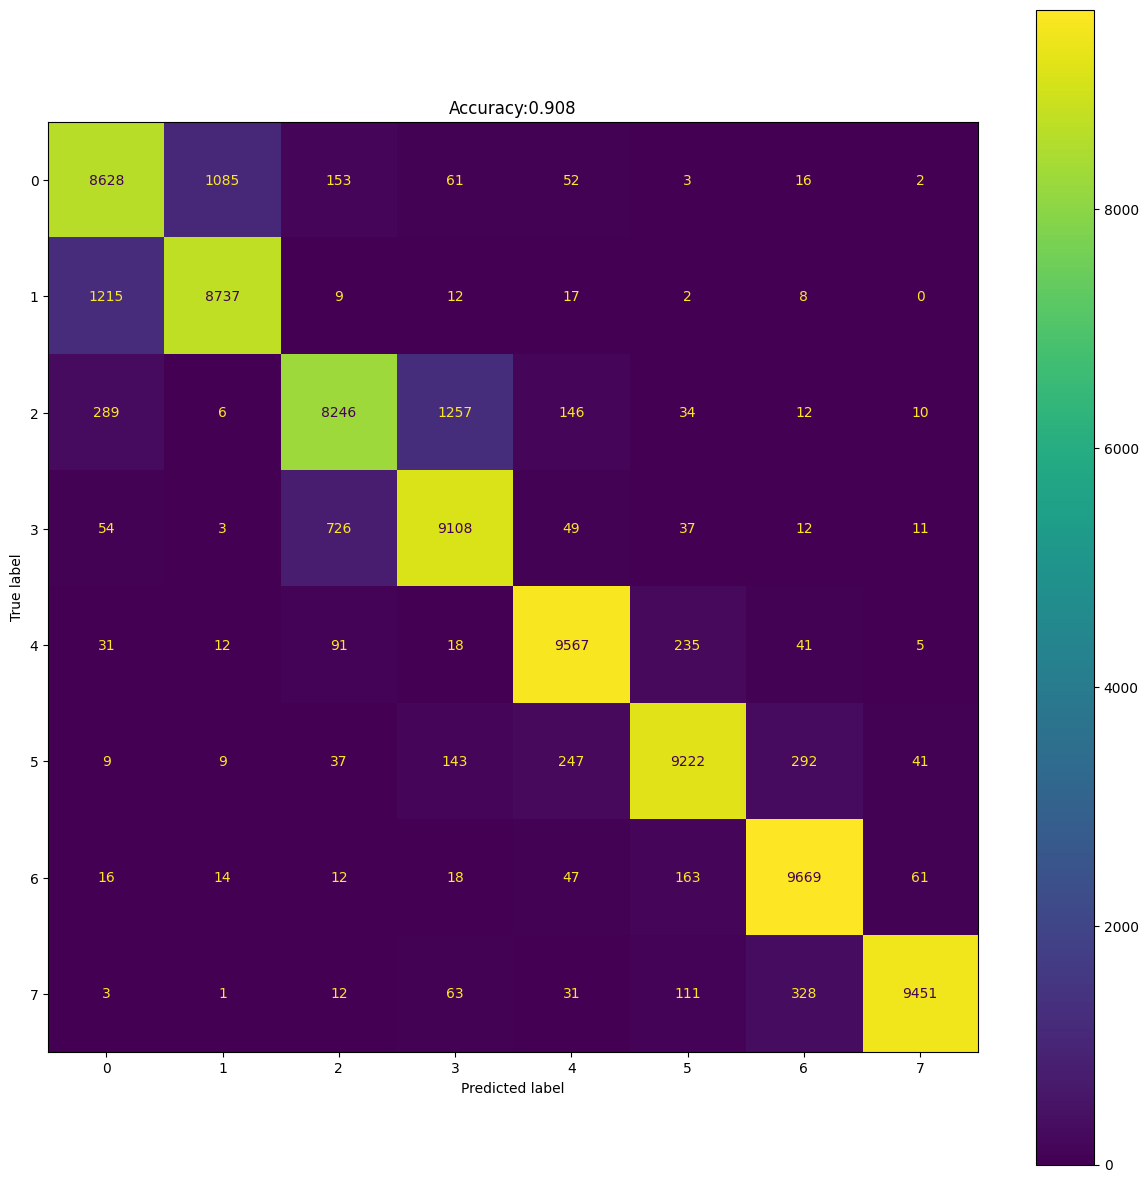

In [46]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Smae Device Other set of Models

Nordic Device-30(i) model to Nordic Device-30(iii) dataset 

In [47]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [48]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 7.2271 - accuracy: 0.1684
test loss, test acc: [7.227139949798584, 0.16842499375343323]


In [49]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 4 4 ... 7 5 7]
7
[[   3    3    9  480 9478    0   25    2]
 [   0  194    1   37 9737    0   31    0]
 [  25    0   44 9874   35    2   18    2]
 [  14    0 1481 8481   19    2    0    3]
 [  15    2   18 9482   36    3  443    1]
 [2482    0 7256  181    2   27   39   13]
 [8207    0 1437   86    5    8  251    6]
 [  74    0  134   10    0 5343    1 4438]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.97      0.02      0.04     10000
           2       0.00      0.00      0.00     10000
           3       0.30      0.85      0.44     10000
           4       0.00      0.00      0.00     10000
           5       0.01      0.00      0.00     10000
           6       0.31      0.03      0.05     10000
           7       0.99      0.44      0.61     10000

    accuracy                           0.17     80000
   macro avg       0.32      0.17  

Test Accuracy:0.168425


Text(0.5, 1.0, 'Accuracy:0.168')

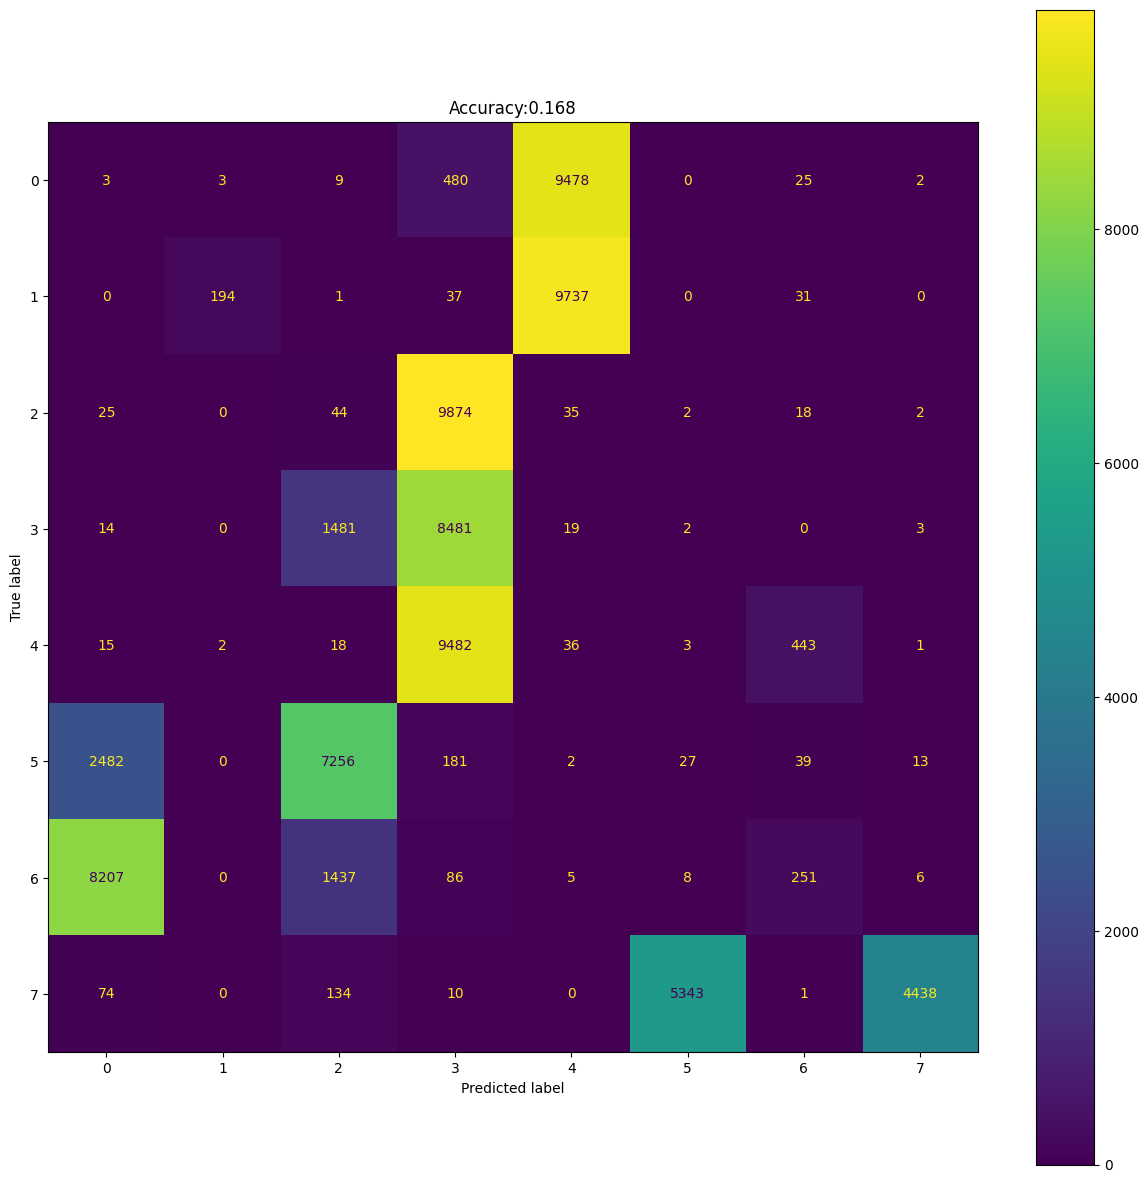

In [50]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other set of samples

In [51]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [52]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [53]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4952 - accuracy: 0.5639
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4875 - accuracy: 0.8593
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4017 - accuracy: 0.8801
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3680 - accuracy: 0.8901
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3504 - accuracy: 0.8949
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3398 - accuracy: 0.8973
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3327 - accuracy: 0.8992
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3274 - accuracy: 0.8992
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3233 - accuracy: 0.9002
Epoch 10/30
2500/2500 [==============================] - 13s 5ms/step - l

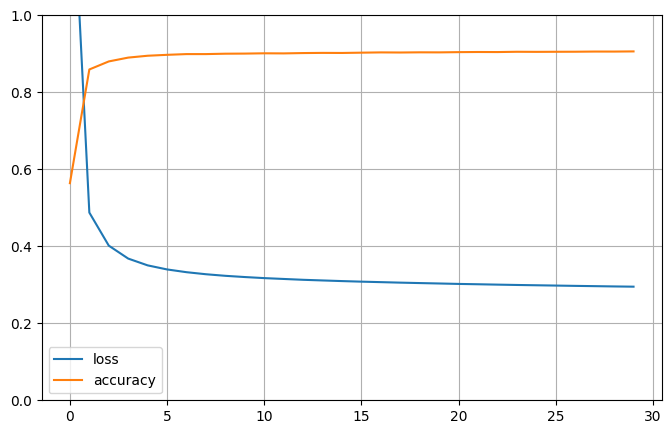

In [54]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [55]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2943 - accuracy: 0.9064
test loss, test acc: [0.2942935526371002, 0.9064499735832214]


In [56]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 0 0 ... 7 7 7]
7
[[9651  136   86   17   88   14    6    2]
 [  47 9912    1    2   37    0    1    0]
 [  65    3 8846  699  298   51   31    7]
 [  14    0  900 8950   63   50   15    8]
 [  23    8  307    4 9587   29   38    4]
 [   3    1   19   36   20 7981 1875   65]
 [   0    1    6   12   40 2150 7765   26]
 [   0    0    1   12    4   68   91 9824]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     10000
           1       0.99      0.99      0.99     10000
           2       0.87      0.88      0.88     10000
           3       0.92      0.90      0.91     10000
           4       0.95      0.96      0.95     10000
           5       0.77      0.80      0.78     10000
           6       0.79      0.78      0.78     10000
           7       0.99      0.98      0.99     10000

    accuracy                           0.91     80000
   macro avg       0.91      0.91  

Test Accuracy:0.90645


Text(0.5, 1.0, 'Accuracy:0.906')

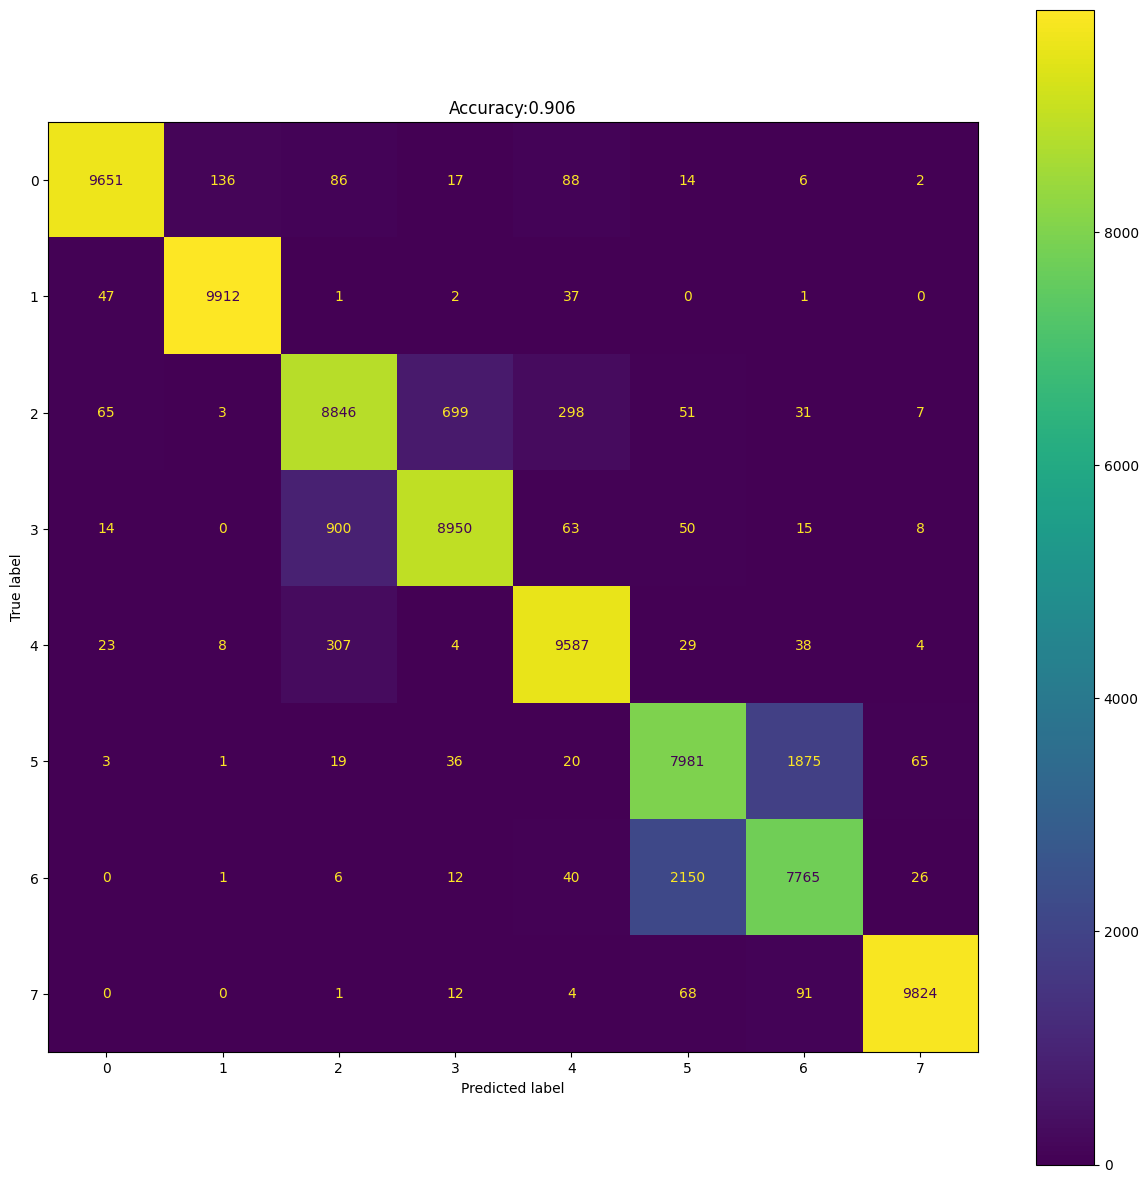

In [57]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(ii) model to Nordic Device-30(iii) dataset 

In [58]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [59]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 7.4604 - accuracy: 0.0712
test loss, test acc: [7.460411071777344, 0.07121250033378601]


In [60]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 3 3 ... 2 2 2]
5
[[  69   37    2 9869    8    3   12    0]
 [  54   62    0 9878    2    3    1    0]
 [6299   20   23 3613    6   17   20    2]
 [9218    0   11  718   16    5   30    2]
 [9840    6   20    8   24   86   12    4]
 [6307    0  105    1    4 3269  312    2]
 [  25    0   22    1   42 9901    6    3]
 [  20    0 8395    0    5   20   34 1526]]
              precision    recall  f1-score   support

           0       0.00      0.01      0.00     10000
           1       0.50      0.01      0.01     10000
           2       0.00      0.00      0.00     10000
           3       0.03      0.07      0.04     10000
           4       0.22      0.00      0.00     10000
           5       0.25      0.33      0.28     10000
           6       0.01      0.00      0.00     10000
           7       0.99      0.15      0.26     10000

    accuracy                           0.07     80000
   macro avg       0.25      0.07  

Test Accuracy:0.0712125


Text(0.5, 1.0, 'Accuracy:0.071')

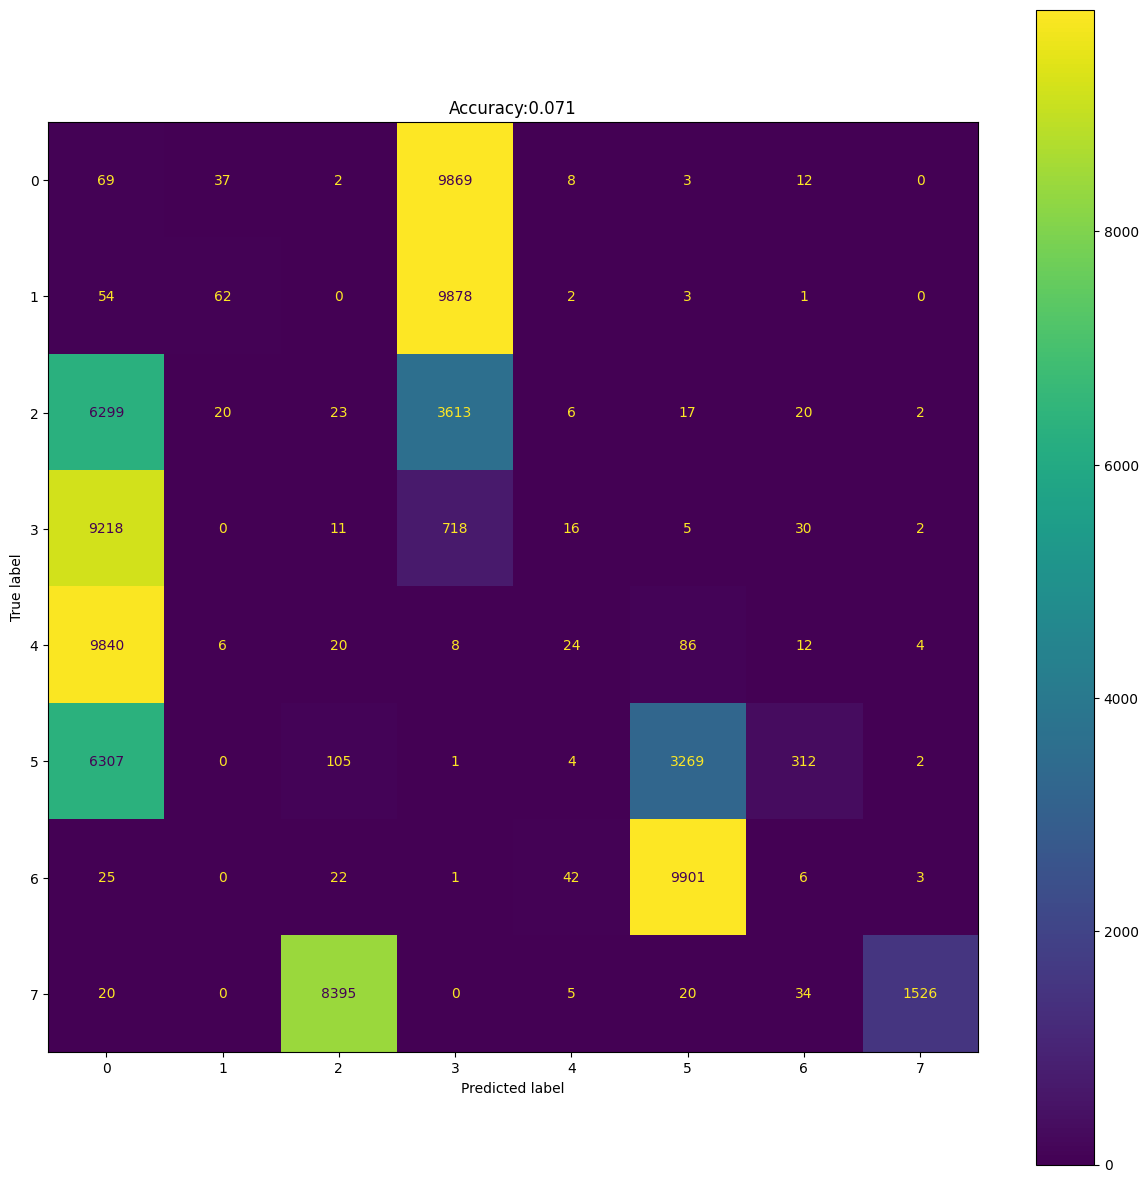

In [61]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [62]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [63]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [64]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.6813 - accuracy: 0.4466
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7112 - accuracy: 0.7930
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5575 - accuracy: 0.8862
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4918 - accuracy: 0.9041
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.4541 - accuracy: 0.9114
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.4284 - accuracy: 0.9162
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4097 - accuracy: 0.9198
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3949 - accuracy: 0.9220
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3829 - accuracy: 0.9250
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss:

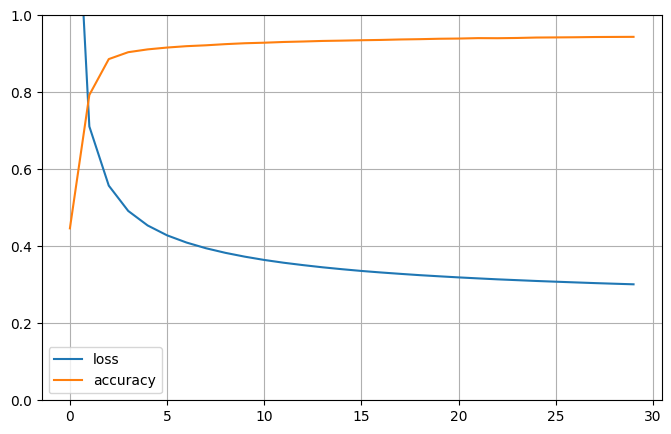

In [65]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [66]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.3010 - accuracy: 0.9445
test loss, test acc: [0.3010053336620331, 0.9445499777793884]


In [67]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 0 0 ... 7 7 7]
5
[[9484  329   68   77   22   15    4    1]
 [ 427 9497   13   30   25    5    3    0]
 [ 181   16 8523 1028  184   33   14   21]
 [  30    0  704 9031  158   56    7   14]
 [   2    1   95   30 9698   98   59   17]
 [   0    0    1   52  174 9587  102   84]
 [   0    0    0    2   46   56 9881   15]
 [   0    0    0   20    0   70   47 9863]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     10000
           1       0.96      0.95      0.96     10000
           2       0.91      0.85      0.88     10000
           3       0.88      0.90      0.89     10000
           4       0.94      0.97      0.96     10000
           5       0.97      0.96      0.96     10000
           6       0.98      0.99      0.98     10000
           7       0.98      0.99      0.99     10000

    accuracy                           0.94     80000
   macro avg       0.94      0.94  

Test Accuracy:0.94455


Text(0.5, 1.0, 'Accuracy:0.945')

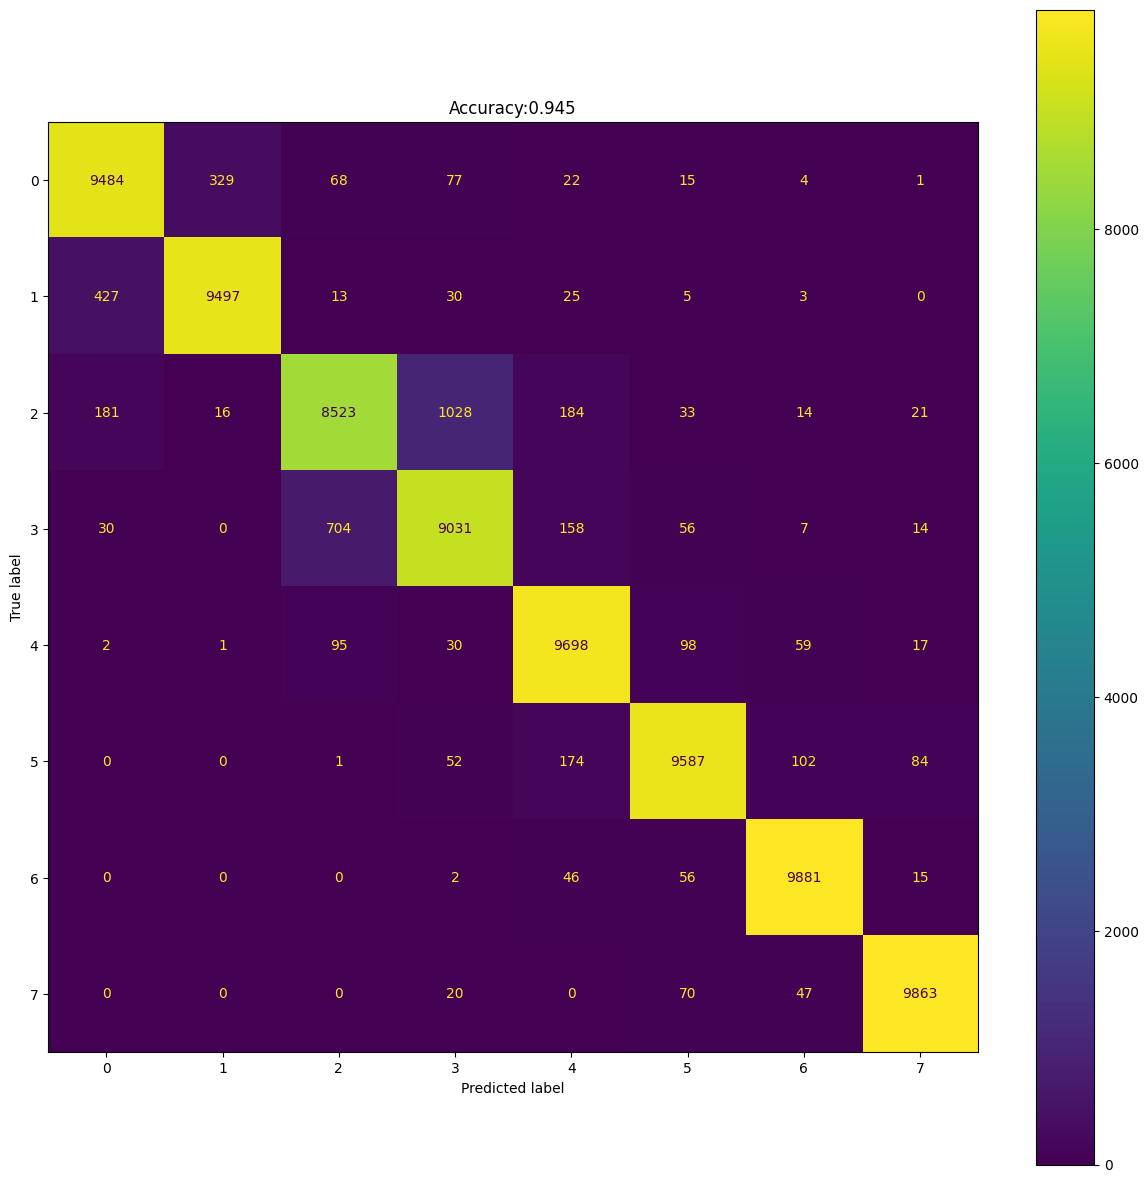

In [68]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')